# Run 2 : TF-IDF

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.utils import simple_preprocess
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

### Chargement des données d'apprentissage et de test

In [2]:
df_train = pd.read_csv("../data/train.csv", sep=',', encoding='utf-8')
df_validation = pd.read_csv("../data/validation.csv", sep=',', encoding='utf-8')
df_test = pd.read_csv("../data/test.csv", sep=',', encoding='utf-8')

### Vectorisation des données

In [3]:
df_train['vecteur'] = df_train['titre'] + " " + df_train['ingredients'] + " " + df_train['recette']
df_validation['vecteur'] = df_validation['titre'] + " " + df_validation['ingredients'] + " " + df_validation['recette']
df_test['vecteur'] = df_test['titre'] + " " + df_test['ingredients'] + " " + df_test['recette']

df_train['tokenize_text'] = [simple_preprocess(text) for text in df_train['vecteur']]
df_validation['tokenize_text'] = [simple_preprocess(text) for text in df_validation['vecteur']]
df_test['tokenize_text'] = [simple_preprocess(text) for text in df_test['vecteur']]

vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df_train['vecteur'])
x_validation = vectorizer.transform(df_validation['vecteur'])
x_test = vectorizer.transform(df_test['vecteur']) 

y_train = df_train["type"]
y_validation = df_validation["type"]
y_test = df_test["type"]

### Apprentissage du SVC

In [4]:
model = SVC(kernel="linear", probability=True)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

### Résultats

In [5]:
score = accuracy_score(y_pred,y_test)
print("Accuracy:", score, "\n")

print(classification_report(y_test, y_pred))

Accuracy: 0.8825648414985591 

                precision    recall  f1-score   support

       Dessert       0.98      1.00      0.99       407
        Entrée       0.79      0.72      0.75       337
Plat principal       0.87      0.89      0.88       644

      accuracy                           0.88      1388
     macro avg       0.88      0.87      0.87      1388
  weighted avg       0.88      0.88      0.88      1388



<Axes: >

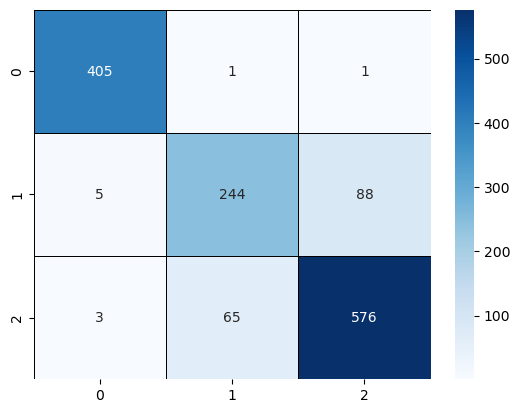

In [6]:
import seaborn as sns 
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")

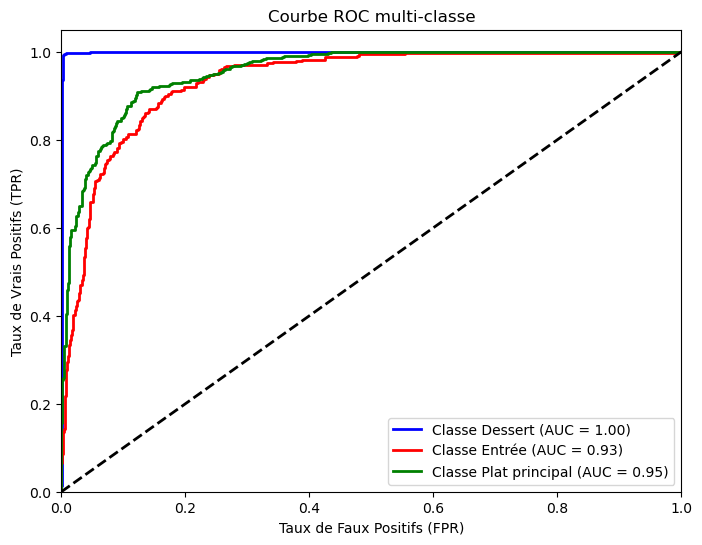

In [7]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = model.predict_proba(x_test)

n_classes = y_test_bin.shape[1]
colors = cycle(['blue', 'red', 'green']) 

plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Classe {lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC multi-classe')
plt.legend(loc='lower right')
plt.show()

In [9]:
max_scores = np.max(y_score, axis=1)
zero_count = np.sum(max_scores == 0)
half_count = np.sum(max_scores < 0.5)
one_count = np.sum((max_scores < 1) & (max_scores > 0.5))

print(f"Documents avec un score de 0   : {zero_count}")
print(f"Documents avec un score de 0.5 : {half_count}")
print(f"Documents avec un score de 1   : {one_count}")

Documents avec un score de 0   : 0
Documents avec un score de 0.5 : 5
Documents avec un score de 1   : 1383
